In [2]:
# Import Libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error



In [3]:
# Specify the path to your CSV file
file_path = 'Reviews.csv'

# Load the dataset 
df = pd.read_csv(file_path)

# Dsiplay the first few rows 
df.head

<bound method NDFrame.head of             Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        HelpfulnessNu

In [4]:
# Extract a random subset of 10,000 reviews
subset_size = 10000
df_subset = df.sample(n= subset_size, random_state=42).reset_index(drop=True)

# Save the subset to a new CSV file
subset_file_path = 'Reviews_subset.csv'
df_subset.to_csv(subset_file_path, index=False)
print(f"Subset saved to {subset_file_path}")

# Display the subset
df_subset.head()

Subset saved to Reviews_subset.csv


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
2,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
3,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


C:\Users\gagra\AppData\Local\Temp\ipykernel_16564\3544042580.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_subset, x='Score', palette='viridis', order=sorted(df_subset['Score'].unique()))


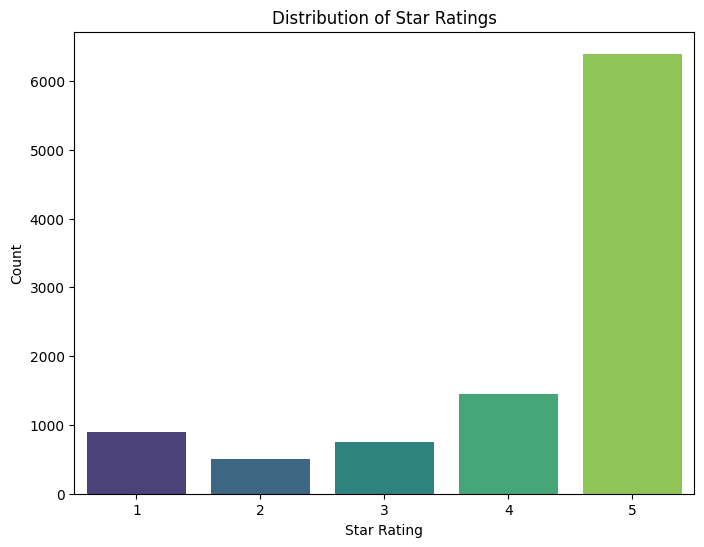

count    10000.000000
mean         4.196000
std          1.296593
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Score, dtype: float64


In [6]:
# Analyze the distribution of star ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df_subset, x='Score', palette='viridis', order=sorted(df_subset['Score'].unique()))
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

# Checking basic statistics of the Score column 
print(df_subset['Score'].describe())

# Drop rows with missing values in critical columns
df = df.dropna(subset=['Text', 'Score'])

# Remove duplicate reviews
df = df.drop_duplicates(subset=['Text', 'Score'])


In [7]:
df[['Text', 'Score']].sample(5)


,Text,Score
412791,Swiss Miss has less chocolate in their hot cho...,1
49958,This is a great bar if you are on the paleo di...,5
356193,THIS IS UNDOUBTEDLY THE BEST TASTING PASTA...A...,5
454886,Wonderful product at a wonderful price (48 can...,5
208534,This mix is really good . . . thanks for makin...,5


In [8]:
# Select the review text and star ratings
X = df_subset['Text']
y = df_subset['Score']

# Preprocess the text and extract TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size {X_test.shape}")

Training set size: (8000, 5000)
Testing set size (2000, 5000)


In [9]:
# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Identify 5 samples where the model made significant errors
errors = abs(y_test - y_pred)  # Absolute error for each prediction

# Create a DataFrame to store the results
error_df = pd.DataFrame({
    'Review': df_subset.loc[y_test.index, 'Text'],  # Use y_test.index to align with the test set
    'True Rating': y_test,
    'Predicted Rating': y_pred,
    'Error': errors
})

# Sort by error and select the top 5 worst predictions
worst_predictions = error_df.sort_values(by='Error', ascending=False).head(5)
worst_predictions[['Review', 'True Rating', 'Predicted Rating', 'Error']]


Mean Absolute Error (MAE): 0.75


,Review,True Rating,Predicted Rating,Error
7826,I love sour food but this one I can't bear. T...,1,4.99,3.99
6426,"We love Happy Baby products - cereals, puffs, ...",1,4.89,3.89
6437,I love cooking with major grey chutney and a h...,1,4.89,3.89
6968,"When I opened the package, the salt did not lo...",1,4.81,3.81
7371,I would love to buy this as a Christmas presen...,1,4.80,3.80


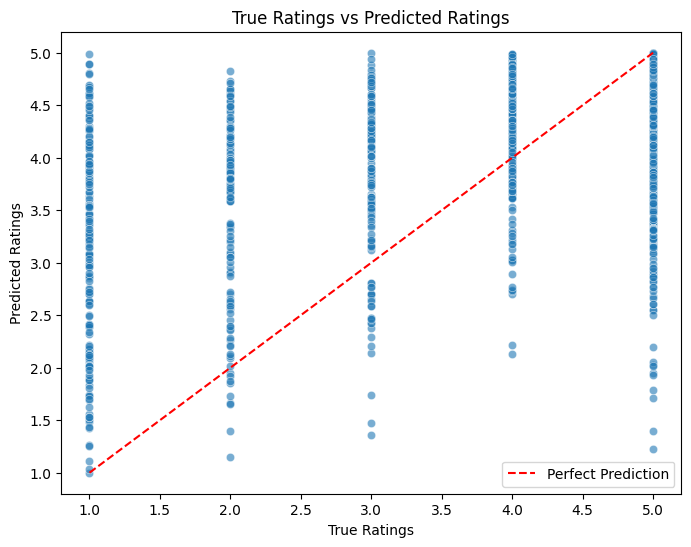

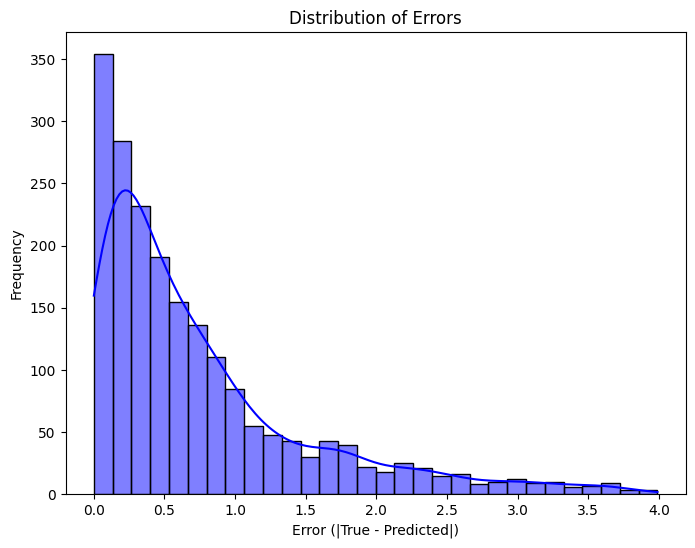

In [10]:
# Plot True Ratings vs Predicted Ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([1, 5], [1, 5], color='red', linestyle='--', label='Perfect Prediction')  # Diagonal line
plt.title('True Ratings vs Predicted Ratings')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()
plt.show()

# Plot Distribution of Errors
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color='blue')
plt.title('Distribution of Errors')
plt.xlabel('Error (|True - Predicted|)')
plt.ylabel('Frequency')
plt.show()

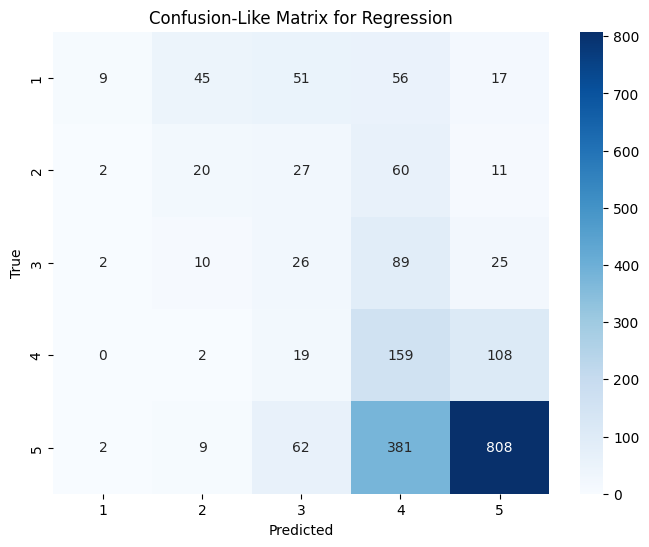

In [1]:
# Create bins for true and predicted ratings
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
y_test_binned = pd.cut(y_test, bins=bins, labels=[1, 2, 3, 4, 5])
y_pred_binned = pd.cut(y_pred, bins=bins, labels=[1, 2, 3, 4, 5])

# Create a confusion-like matrix
confusion_matrix = pd.crosstab(y_test_binned, y_pred_binned, rownames=['True'], colnames=['Predicted'])

# Plot the confusion-like matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion-Like Matrix for Regression')
plt.show()